## CNN for waveform binary classification

The aim is to discriminate between two types of waveforms using a **1D convolutional neural network** :

| Classes | Sine wave (C0) | Gaussian sine wave (C1) |
|:---|:---:|:---:|
| *Equation* | &nbsp; &nbsp; $y_0 = A_0 sin(2\pi f_0(t-t_0)) + \phi_0$ &nbsp; &nbsp; | &nbsp; &nbsp; $y_1 = A_0 e^{-(t-t_0)^2/2\sigma_0^2} cos(2\pi f_0(t-t_0)) + \phi_0$ &nbsp; &nbsp;|
| *Parameters* | $A_0, f_0, t_0, \phi_0$ | $A_0, f_0, t_0, \phi_0, \sigma_0$ |

### Model

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Cnn1d(nn.Module):

    def __init__(self):
        super(Cnn1d, self).__init__()
        # [1,1,1000]
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=6,
                                kernel_size=3, padding=1)
        # [1,6,1000]
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        # [1,6,500]
        self.conv_2 = nn.Conv1d(in_channels=6, out_channels=16,
                                kernel_size=3, padding=1)
        # [1,16,500]
        # After pooling : [1,16,250]
        self.full_connect_1 = nn.Linear(16*250, 500)
        self.full_connect_2 = nn.Linear(500, 100)
        self.full_connect_3 = nn.Linear(100, 2)

    def forward(self, input):
        input = self.maxpool(F.relu(self.conv_1(input)))
        input = self.maxpool(F.relu(self.conv_2(input)))
        input = input.view(1, 16*250)
        input = F.relu(self.full_connect_1(input))
        input = F.relu(self.full_connect_2(input))
        input = F.softmax(self.full_connect_3(input))
        return input

### Input/0utput

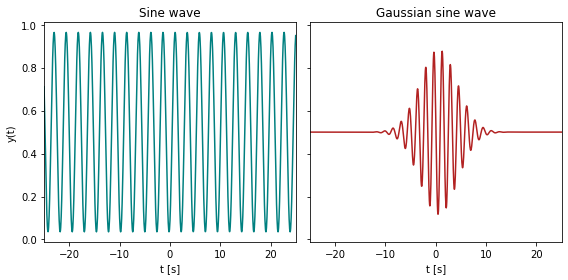

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Waveform generation functions
# (positive not to lose information with ReLU activation)
def sine_wave(t, A0, f0, t0, phi0):
    return A0 * np.sin(2.*np.pi*f0*(t-t0) + phi0) + 0.5

def gaussian_sine_wave(t, A0, f0, t0, phi0, tau0):
    return A0 * np.exp(-0.5*((t-t0)/tau0)**2) * \
        np.cos(2.*np.pi*f0*(t-t0) + phi0) + 0.5

# Random wave parameters
N_samples = 100
# Note : only half of this number (half_sample) will be generated
# as waveforms
half_sample = int(N_samples/2)
sample_sz = 1000
A0s = np.random.uniform(0, 0.5, N_samples)
f0s = np.random.uniform(0, 1, N_samples)
t0s = np.random.uniform(-2, 2, N_samples)
phi0s = np.random.uniform(0, 2*np.pi, N_samples)
tau0s = np.random.uniform(0.1, 10, half_sample)

# Generating waveforms
t = np.linspace(-25, 25, sample_sz)
training_sines = []
training_Gsines = []
for i in range(half_sample):
    training_sines.append(torch.from_numpy(sine_wave(t, A0s[i],
    f0s[i], t0s[i], phi0s[i])))
    training_Gsines.append(torch.from_numpy(gaussian_sine_wave(t,
    A0s[half_sample+i],f0s[half_sample+i],
    t0s[half_sample+i], phi0s[half_sample+i], tau0s[i])))
    # Expanding dimensions to obtain a [N,C_in,L] input
    training_sines[i] = training_sines[i].unsqueeze(0).unsqueeze(0)
    training_Gsines[i] = training_Gsines[i].unsqueeze(0).unsqueeze(0)

# Mixing inputs and associating outputs
labels = np.random.randint(0, 2, half_sample)
training_inputs = []
training_outputs = []
for i in range(half_sample):
    if labels[i] == 0:
        training_inputs.append(training_sines[i])
        training_outputs.append(torch.tensor([[1,0]]))
    else:
        training_inputs.append(training_Gsines[i])
        training_outputs.append(torch.tensor([[0,1]]))

# Display of the 2 classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax1.plot(t, training_sines[1][0][0].numpy(), c="teal")
ax2.plot(t, training_Gsines[1][0][0].numpy(), c="firebrick")
ax1.set(title="Sine wave", xlabel=r"t [s]", ylabel=r"y(t)",
        xlim=(t[0], t[-1]))
ax2.set(title="Gaussian sine wave", xlabel=r"t [s]",
        xlim=(t[0], t[-1]))
fig.tight_layout()

### Training

Done training.



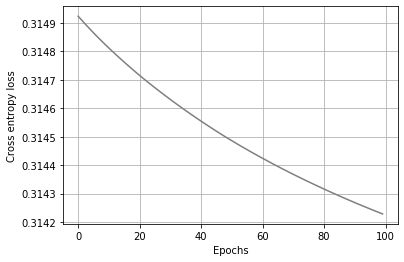

In [7]:
import torch.optim as optim
import pdb

# CNN instance
model = Cnn1d()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
learning_rate = 1e-2

# Loss function : cross entropy // Optimizer : stochastic gradient descent
loss_fn = nn.CrossEntropyLoss() # Relevant for multiclasses classification
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training
epochs = np.arange(100)
errors = np.zeros(len(epochs))
for i in range(half_sample):
    for epoch in epochs:
        # Forward + backward + optimize
        output = model.forward(training_inputs[i].float())
        loss = loss_fn(output, torch.tensor([labels[i]]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Keeping trace of the loss function
        errors[epoch] = loss
    print("\rTraining {:.0f}%".format(i/half_sample*100), end="", flush=True)
print("\rDone training.\n")

# Evolution of the loss function for the last I/O
fig, ax = plt.subplots()
ax.plot(epochs, errors, c="tab:gray")
ax.set(xlabel="Epochs", ylabel="Cross entropy loss")
ax.grid()

### Test / performance

In [8]:
# Sampling
N = 2000
halfN = int(N/2)

# Wave parameters
test_A0s = np.random.uniform(0, 0.5, N)
test_f0s = np.random.uniform(0, 1, N)
test_t0s = np.random.uniform(-2, 2, N)
test_phi0s = np.random.uniform(0, 2*np.pi, N)
test_tau0s = np.random.uniform(0.1, 10, halfN)

# Generating waveforms
test_sines = []
test_Gsines = []
for i in range(halfN):
    test_sines.append(torch.from_numpy(sine_wave(t, test_A0s[i],
    test_f0s[i], test_t0s[i], test_phi0s[i])))
    test_Gsines.append(torch.from_numpy(gaussian_sine_wave(t,
    test_A0s[halfN+i], test_f0s[halfN+i], test_t0s[halfN+i],
    test_phi0s[halfN+i], test_tau0s[i])))
    # Expanding dimensions to obtain a [N,C_in,L] input
    test_sines[i] = test_sines[i].unsqueeze(0).unsqueeze(0)
    test_Gsines[i] = test_Gsines[i].unsqueeze(0).unsqueeze(0)

# Random mixing of test inputs and associating outputs
test_labels = np.random.randint(0, 2, halfN)
test_inputs = []
for i in range(halfN):
    if test_labels[i] == 0:
        test_inputs.append(test_sines[i])
    else:
        test_inputs.append(test_Gsines[i])

# Feedforward
predicted_labels = np.zeros(halfN)
scores = torch.zeros(halfN, 2)
for i in range(halfN):
    score = model.forward(test_inputs[i].float())[0]
    scores[i] = score

"""
# ROC curves / AUC
from sklearn.metrics import roc_curve, roc_auc_score

PFA0, PDET0, thresh0 = roc_curve(scores[:][0].numpy(), predicted_labels)
PFA1, PDET1, thresh1 = roc_curve(scores[:][1].numpy(), predicted_labels)
AUC0 = roc_auc_score(scores[:][0].numpy(), predicted_labels)
AUC1 = roc_auc_score(scores[:][1].numpy(), predicted_labels)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax.plot(PFA0, PDET0, c="teal", label="Sine wave // AUC = {:.2f}".format(AUC0))
ax.plot(PFA1, PDET1, c="firebrick", lable="Gaussian sine wave // AUC = {:.2f}".format(AUC0))
ax.plot([0,1], [0,1], "--", c="k")
ax.set(xlabel=r"P$_{FA}$", ylabel=r"P$_{DET}$", title="ROC")
ax.grid()
ax.legend()
"""

'\n# ROC curves / AUC\nfrom sklearn.metrics import roc_curve, roc_auc_score\n\nPFA0, PDET0, thresh0 = roc_curve(scores[:][0].numpy(), predicted_labels)\nPFA1, PDET1, thresh1 = roc_curve(scores[:][1].numpy(), predicted_labels)\nAUC0 = roc_auc_score(scores[:][0].numpy(), predicted_labels)\nAUC1 = roc_auc_score(scores[:][1].numpy(), predicted_labels)\n\nfig, ax = plt.subplots(1, 2, figsize=(10,5))\nax.plot(PFA0, PDET0, c="teal", label="Sine wave // AUC = {:.2f}".format(AUC0))\nax.plot(PFA1, PDET1, c="firebrick", lable="Gaussian sine wave // AUC = {:.2f}".format(AUC0))\nax.plot([0,1], [0,1], "--", c="k")\nax.set(xlabel=r"P$_{FA}$", ylabel=r"P$_{DET}$", title="ROC")\nax.grid()\nax.legend()\n'

In [9]:
scores

tensor([[0.0018, 0.9982],
        [0.0018, 0.9982],
        [0.0018, 0.9982],
        ...,
        [0.0017, 0.9983],
        [0.0016, 0.9984],
        [0.0018, 0.9982]], grad_fn=<CopySlices>)